# Walkthrough - Gamma in the Distribution Sapce



In [243]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import warnings
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.distribution import DataParams

from features.utils import dict_product


# Kernel Dependency measure
from pysim.kernel.hsic import HSIC
from pysim.kernel.utils import estimate_gamma, GammaParam

# RBIG IT measures
from models.ite_algorithms import run_rbig_models
from models.dependence import HSICModel

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datasets

* Samples - [500, 1K, 5K, 10K, 30K, 50K]
* Dimensions - [ 2, 3, 10, 50, 100]
* trials - `1:5`
* IT measures - Mutual Information
* Distributions - [Gaussian, T-Student]

## Example Gaussian Distribution: 2D

#### 1. Generate Data

In [220]:
DataParams?

Init signature:
DataParams(
    dataset: str = 'gauss',
    samples: int = 100,
    dimensions: int = 2,
    std: int = 1,
    trial: int = 1,
    nu: int = 1,
) -> None
Docstring:     
A dataclass which holds all of the options to 
generate datasets. 

Parameters
-------
trials : int, default=1
    {1, 2, 3, 4, 5}

samples : int, default=100
    {50, 100, 500, 1_000, 5_000}

dimensions : int, default = 2
    {2, 3, 10, 50, 100}

std : int, default=2
    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
    
nu : int, default = 2 
    {1, 2, 3, 4, 5, 6, 7, 8, 9}
File:           ~/projects/2019_hsic_align/src/data/distribution.py
Type:           type
Subclasses:     


In [221]:
example_params = DataParams()
example_params

Dataset: gauss
Samples: 100
Dimensions: 2
Standard Deviation: 1
Nu: 1
Trial: 1

In [222]:
example_params.dataset

'gauss'

In [223]:
example_params.generate_data?

Signature: example_params.generate_data() -> data.distribution.Inputs
Docstring:
Helper function to generate data using the 
parameters above.
File:      ~/projects/2019_hsic_align/src/data/distribution.py
Type:      method


In [225]:
inputs = example_params.generate_data()
inputs?

Type:        Inputs
String form:
Inputs(X=array([[ 0.97944888,  0.33959587],
           [-0.26561127, -0.73802495],
           [-0.5483727 <...> 10155 ],
           [-1.5919696 ,  0.30211001],
           [-0.2814283 , -0.90755104]]), mutual_info=0.0)
Length:      3
File:        ~/projects/2019_hsic_align/src/data/distribution.py
Docstring:  
Helpful data holder which stores:

X : np.ndarray, (n_samples, n_features)

Y : np.ndarray, (n_samples, n_features)

mutual_info : float
    the mutual information value


#### 2. Plot Data

<Figure size 720x720 with 0 Axes>

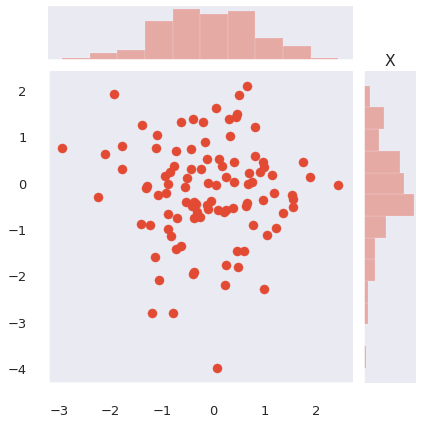

<Figure size 720x720 with 0 Axes>

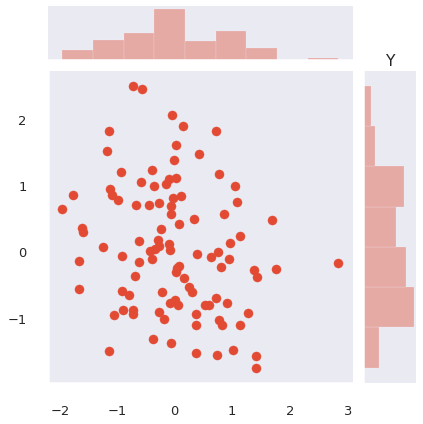

In [226]:
# plot data
fig  = plt.figure(figsize=(10, 10))

g = sns.jointplot(
    x=inputs.X[:, 0],
    y=inputs.X[:, 1],
)
plt.title('X')
plt.show()

# plot data
fig  = plt.figure(figsize=(10, 10))

g = sns.jointplot(
    x=inputs.Y[:, 0],
    y=inputs.Y[:, 1],
)
plt.title('Y')
plt.show()

## HSIC Algorithms

### HSIC

**algorithm path**: *src/models/dependence.py*

#### 1. Estimate Gamma

In [239]:
# init gamma estimator
gamma_estimator = GammaParam(method='median', percent=None, scale=None)

# estimate sigma
gamma_X = gamma_estimator.estimate_gamma(X=inputs.X, )
gamma_Y = gamma_estimator.estimate_gamma(X=inputs.Y, )

print(f'Gamma_x: ', gamma_X)
print(f'Gamma_y: ', gamma_Y)

Gamma_x:  0.7023907854424224
Gamma_y:  0.8115698604887414


#### 2. Estimate HSIC

In [235]:
# init hsic model class
hsic_model = HSICModel()

# hsic model params
hsic_model.gamma_X = gamma_X
hsic_model.gamma_Y = gamma_Y

# get hsic score
hsic_val = hsic_model.get_score(inputs.X, inputs.Y, 'hsic')

print(f"HSIC: {hsic_val:.5f}")

HSIC: 0.00550


## Experiment I - Different Scorers

We are looking at different "HSIC scorers". They are:

---
**HSIC**

$$HSIC = \frac{1}{n(n-1)}\langle K_xH,K_yH \rangle_F$$

Notice: we have the centered kernels, $K_xH$ and no normalization.

---
**TKA** 

$$TKA = \frac{\langle K_x,K_y \rangle_F}{||K_x||_F||K_y||_F}$$

Notice: We have the uncentered kernels and a normalization factor.

---
**cTKA**

$$cTKA = \frac{\langle K_xH,K_yH \rangle_F}{||K_xH||_F||K_yH||_F}$$

Notice: We have the centered kernels and a normalization factor.

In [236]:
# experimental parameters
hsic_model = HSICModel()

# hsic model params
hsic_model.gamma_X = gamma_X
hsic_model.gamma_Y = gamma_Y



scores = dict()

# loop through scorers
for iscorer in ['hsic', 'ka', 'cka']:
    
    # calculate hsic score
    iscore = hsic_model.get_score(inputs.X, inputs.Y, iscorer)
    
    # get HSIC value
    print(f'{iscorer.upper()}: {iscore:.4f}')

HSIC: 0.0055
KA: 0.4690
CKA: 0.0860


There is an obvious difference between each of them even though the distribution hasn't changed at all. It's clear that each of the methods have a slightly different form. So perhaps it's something to do with the parameters we've chosen. We need to investigate things further.

## Experiment II - Gamma Space

### Method 2 - Multiprocessing

In [365]:
from experiments.utils import dict_product, run_parallel_step

In [366]:
# Data Parameters
example_data = DataParams()
example_data.std = 10
inputs = example_data.generate_data()


# experimental parameters
n_grid_points = 50
gamma_grid = np.logspace(-2, 2, n_grid_points)
parameters = {
    "scorer": ['hsic', 'ka', 'cka'],
    "gamma_X": np.copy(gamma_grid),
    "gamma_Y": np.copy(gamma_grid),
}

# create a list of all param combinations
parameters = list(dict_product(parameters))
n_params = len(parameters)
print('# of Params:', n_params)

# of Params: 7500


In [367]:
# define step function
def step(params: Dict, inputs):
    
    # init hsic model class
    hsic_model = ModelParams()
    
    # hsic model params
    hsic_model.gamma_X = params['gamma_X']
    hsic_model.gamma_Y = params['gamma_Y']

    # get hsic score
    score = hsic_model.get_score(inputs.X, inputs.Y, params['scorer'])
    
    results_df = pd.DataFrame({
        'scorer': [params['scorer']],
        'gamma_X': [params['gamma_X']],
        'gamma_Y': [params['gamma_Y']],
        'score': score,
    },)
    
    return results_df

In [368]:
verbose = 1
n_jobs = 5

results = run_parallel_step(
    exp_step=step, 
    parameters=parameters,
    n_jobs=n_jobs,
    verbose=verbose,
    inputs=inputs
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 7176 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done 7500 out of 7500 | elapsed:    9.2s finished


In [369]:
results_full_df = pd.concat(results, ignore_index=True)
results_full_df.tail()

,scorer,gamma_X,gamma_Y,score
7495,cka,100.0,47.148664,0.818098
7496,cka,100.0,56.898660,0.835625
7497,cka,100.0,68.664885,0.851295
7498,cka,100.0,82.864277,0.865192
7499,cka,100.0,100.000000,0.877417


### Viz - Heatmap of Values

In [370]:
def plot_gamma_grid(grid_df: pd.DataFrame, scorer: str, ax: Optional=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6.5))
    
    # ===========================================
    # Plot Gridded DataFrame
    # ===========================================
    

    # subset hsic method
    grid_df_ = grid_df[grid_df['scorer'] == scorer].drop('scorer', axis=1)
    
    # create a heatmap
    grid_df_ = pd.pivot_table(grid_df_, values='score', index=['gamma_Y'], columns='gamma_X')
#     print(grid_df_)
    # min max
    if scorer == 'hsic':
        vmax = 0.11
    else:
        vmax = 1.0

    # heatmap_data.columns = np.sqrt(1 / 2 * heatmap_data.columns.values)
    # heatmap_data.index = np.sqrt(1 / 2 * heatmap_data.index.values)
    pts = sns.heatmap(
        data=grid_df_,
        xticklabels=grid_df_.columns.values.round(decimals=2),
        yticklabels=grid_df_.index.values.round(decimals=2),
        vmin=0, vmax=vmax, ax=ax
    )
    

    return plt.gcf(), ax

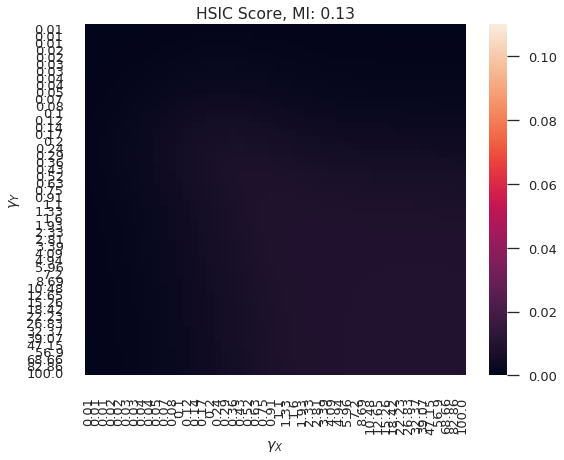

In [371]:
# # =======================
# # HSIC
# # =======================
# scorer = 'hsic'

# fig, ax = plot_gamma_grid(param_df, scorer=scorer)

# # ax.legend(ncol=1, fontsize=15)
# ax.set_xlabel(r'$\gamma_X$')
# ax.set_ylabel(r'$\gamma_Y$')
# ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
# plt.tight_layout()
# plt.show()

# # =======================
# # Kernel Alignment
# # =======================
# scorer = 'ka'

# fig, ax = plot_gamma_grid(param_df, scorer=scorer)

# # ax.legend(ncol=1, fontsize=15)
# ax.set_xlabel(r'$\gamma_X$')
# ax.set_ylabel(r'$\gamma_Y$')
# ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
# plt.tight_layout()
# plt.show()

# ==========================
# Centered Kernel Alignment
# ==========================
scorer = 'hsic'

fig, ax = plot_gamma_grid(results_full_df, scorer=scorer)

# ax.legend(ncol=1, fontsize=15)
ax.set_xlabel(r'$\gamma_X$')
ax.set_ylabel(r'$\gamma_Y$')
ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
plt.tight_layout()
plt.show()

## Experiment III - Gamma Estimators 

In [372]:
# Data Parameters
example_data = DataParams()
example_data.std = 10
inputs = example_data.generate_data()


# experimental parameters
parameters = {
    "scorer": ['hsic', 'ka', 'cka'],
    "gamma_est": [
    ('silverman',None, None),
    ('scott', None, None),
    *[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
]
}

# create a list of all param combinations
parameters = list(dict_product(parameters))
n_params = len(parameters)
print('# of Params:', n_params)

# of Params: 33


In [364]:
type(parameters[0])

dict

In [373]:
from tqdm import tqdm


# init hsic model class
hsic_model = ModelParams()

# results dataframe
gamma_ests = list()


# run experiment
for iparams in tqdm(parameters):
    
    # estimate gamma
    gamma_X = estimate_gamma(
        X=inputs.X, 
        method=iparams['gamma_est'][0], 
        percent=iparams['gamma_est'][1], 
        scale=iparams['gamma_est'][2]
    )
    gamma_Y = estimate_gamma(
        X=inputs.Y, 
        method=iparams['gamma_est'][0], 
        percent=iparams['gamma_est'][1], 
        scale=iparams['gamma_est'][2]
    )
    
        


    # hsic model params
    hsic_model.gamma_X = gamma_X
    hsic_model.gamma_Y = gamma_Y

    # get hsic score
    score = hsic_model.get_score(inputs.X, inputs.Y, iparams['scorer'])
        
        
#         # init gamma estimator
#         gamma_est = GammaParam(*imethod)
        
#         # initialize gamma
#         gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
        
#         # get hsic_value
#         hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=False)
        
        # append results to dataframe
    gamma_ests.append(
        pd.DataFrame({
        'scorer': [iscorer],
        'gamma_method': [gamma_est.method],
        'gamma_scale': [gamma_est.scale],
        'gamma_percent': [gamma_est.percent],
        'gamma_X': [gamma_X],
        'gamma_Y': [gamma_Y],
        'score': [score],
    }))
        
# results_df.head()

100%|██████████| 33/33 [00:00<00:00, 149.05it/s]


In [374]:
gamma_ests_df = pd.concat(gamma_ests, ignore_index=True)

In [375]:
gamma_ests_df.tail()

,scorer,gamma_method,gamma_scale,gamma_percent,gamma_X,gamma_Y,score
28,cka,median,None,None,0.201849,0.240391,0.144038
29,cka,median,None,None,0.149283,0.183536,0.154599
30,cka,median,None,None,0.112474,0.142939,0.164639
31,cka,median,None,None,0.087687,0.116909,0.172534
32,cka,median,None,None,0.062305,0.082550,0.183174


In [376]:
from typing import List

def plot_estimated_params(
    ax, 
    gamma_est_df: pd.DataFrame, 
    gamma_estimators: List, 
    scorer: str
):
    # subset hsic method
    df_ = gamma_est_df[gamma_est_df['scorer'] == scorer]
    
    # subset gamma estimators
    for iestimator in gamma_estimators:
        # subsets
        sub_df = df_[df_['gamma_method'] == iestimator[0]]
        if iestimator[1] is not None:
            sub_df = sub_df[sub_df['gamma_percent'] == iestimator[1]]
        if iestimator[2] is not None:
            sub_df = sub_df[sub_df['gamma_scale'] == iestimator[2]]
        
        name = list(filter(None, iestimator))
        name = '_'.join(str(i) for i in name)
        ax.scatter(
            sub_df.gamma_X, 
            sub_df.gamma_Y,
            s=500, label=f"{name}", zorder=3, marker='.')

    
    return ax

In [ ]:

# ==========================
# Centered Kernel Alignment
# ==========================
scorer = 'cka'

# Plot Grid
fig, ax = plot_gamma_grid(param_df, scorer=scorer)

# Plot points
ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

ax.legend(ncol=1, fontsize=8)
ax.set_xlabel(r'$\gamma_X$')
ax.set_ylabel(r'$\gamma_Y$')
ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
plt.tight_layout()
plt.show()

### Viz - Combined Function


In [ ]:
def plot_dist_params(param_df, gamma_ests_df, gamma_estimators, scorer: str):

    # Plot Grid
    fig, ax = plot_gamma_grid(param_df, scorer=scorer)

    # Plot points
    ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

    ax.legend(ncol=1, fontsize=8)
    ax.set_xlabel(r'$\gamma_X$')
    ax.set_ylabel(r'$\gamma_Y$')
    ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
    plt.tight_layout()
    plt.show()

In [ ]:

plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'hsic')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'ka')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'cka')
